In [3]:
## Step 0: Imports


In [4]:
# Imports here
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
import os

In [5]:
## Step 1: Load and split data

In [6]:
# Path to your data folder
data_dir = 'data'

# Load the dataset using ImageFolder
full_dataset  = ImageFolder(root=data_dir)#, transform=transform)

# Define the percentage of data to be used for testing and validation
test_split = 0.2
valid_split = 0.1

# Calculate the number of samples for training, testing and validation
num_samples = len(full_dataset )
num_test_samples = int(test_split * num_samples)
num_valid_samples = int(valid_split * num_samples)
num_train_samples = num_samples - num_test_samples - num_valid_samples

# Split the dataset into training, validation and testing sets
train_data, valid_data, test_data = random_split(full_dataset , [num_train_samples, num_valid_samples, num_test_samples])


In [7]:
## Step 2: Transform Data

In [8]:
# Training transform includes random rotation and flip to build a more robust model
train_transforms = transforms.Compose([transforms.Resize((244,244)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# The validation set will use the same transform as the test set
test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validation_transforms = transforms.Compose([transforms.Resize((244,244)),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [9]:
# Apply the transforms to the subsets
train_data.dataset.transform = train_transforms
valid_data.dataset.transform = validation_transforms
test_data.dataset.transform = test_transforms

# Create dataloaders for training, validation and testing sets
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
print(len(trainloader))
validloader = DataLoader(valid_data, batch_size=32, shuffle=True)
print(len(validloader))
testloader = DataLoader(test_data, batch_size=32, shuffle=True)
print(len(testloader))


124
71
142


In [10]:
## Step 3: Create Model

In [11]:
#model = models.densenet121(pretrained=True)
model = models.resnet34(pretrained=True)

c:\Users\max\OneDrive - University of Bristol\Uni\Year 3\AI\torch_env2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\max\OneDrive - University of Bristol\Uni\Year 3\AI\torch_env2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 391)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [14]:
## Step 4: Train Model

In [15]:
# Implement a function for the validation pass
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    
    # change model to work with cpu
    model.to('cpu')

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):
    
        # Change images and labels to work with cpu
        images, labels = images.to('cpu'), labels.to('cpu')

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)
        
        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [16]:
epochs = 8
steps = 0
print_every = 40

# change to gpu mode
model.to('cpu')
model.train()
for e in range(epochs):

    running_loss = 0
    
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to('cpu'), labels.to('cpu')
        
        # zeroing parameter gradients
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()
            
            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every,3)} \
            Valid Loss: {round(valid_loss/len(validloader),3)} \
            Valid Accuracy: {round(float(accuracy/len(validloader)),3)}")
            
            
            # Turning training back on
            model.train()
            lrscheduler.step(accuracy * 100)

No. epochs: 1,             Training Loss: 5.592             Valid Loss: 4.921             Valid Accuracy: 0.07
No. epochs: 1,             Training Loss: 9.954             Valid Loss: 3.859             Valid Accuracy: 0.205
No. epochs: 1,             Training Loss: 13.344             Valid Loss: 3.182             Valid Accuracy: 0.284
No. epochs: 2,             Training Loss: 2.144             Valid Loss: 2.527             Valid Accuracy: 0.444
No. epochs: 2,             Training Loss: 4.148             Valid Loss: 2.266             Valid Accuracy: 0.471
No. epochs: 2,             Training Loss: 5.849             Valid Loss: 1.966             Valid Accuracy: 0.542
No. epochs: 3,             Training Loss: 0.868             Valid Loss: 1.783             Valid Accuracy: 0.585
No. epochs: 3,             Training Loss: 1.773             Valid Loss: 1.551             Valid Accuracy: 0.642
No. epochs: 3,             Training Loss: 2.586             Valid Loss: 1.245             Valid Accuracy

In [17]:
correct = 0
total = 0
model.to('cpu')


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cpu'), labels.to('cpu')
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")

Test accuracy of model: 72.236%


In [18]:
## Step 5: Save the Model

In [19]:
# # Saving: feature weights, new model.fc, index-to-class mapping, optimiser state, and No. of epochs
# checkpoint = {'state_dict': model.state_dict(),
#               'model': model.fc,
#               'class_to_idx': train_data.class_to_idx,
#               'opt_state': optimizer.state_dict,
#               'num_epochs': epochs}

# torch.save(checkpoint, 'models/my_checkpoint2.pth')

checkpoint = {'state_dict': model.state_dict(),
              'model': model.fc,
              'class_to_idx': full_dataset.class_to_idx,  # Access class_to_idx from the original dataset
              'opt_state': optimizer.state_dict(),
              'num_epochs': epochs}

torch.save(checkpoint, 'models/my_checkpoint2.pth')

In [20]:
## Step 6: Load the Model

In [21]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):

    checkpoint = torch.load(filepath)
    
    #model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [22]:

# Loading model
model = load_checkpoint('models/my_checkpoint2.pth')
# Checking model i.e. should have 196 output units in the classifier
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
model = torch.nn.DataParallel(model)

In [24]:
## Step 7: Predict the Image

In [25]:
def process_image(image):
    
    # Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg')

    # Building image transform
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]) 
    
    # Transforming image for use with network
    pil_tfd = transform(pil_im)
    
    # Converting to Numpy array 
    array_im_tfd = np.array(pil_tfd)
    
    return array_im_tfd

In [26]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

<Axes: >

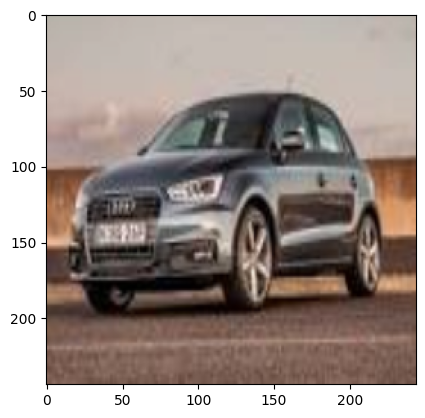

In [27]:
imshow(process_image(data_dir + '/1/audi_1'))

In [28]:
def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file   
    
    # Loading model - using .cpu() for working with CPUs
    loaded_model = load_checkpoint(model).cpu()#to('cpu')
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)
        
    #conf, predicted = torch.max(output.data, 1)   
    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]
    
    # Converting probabilities and outputs to lists
    conf = np.array(probs_top)[0]
    predicted = np.array(predicted_top)[0]
        
    #return probs_top_list, index_top_list
    return conf, predicted

In [29]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('Ident/class_names.csv')

# Convert the DataFrame into a dictionary
folder_to_class = df.set_index('folder_name')['class_name'].to_dict()


In [30]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return list(folder_to_class.values()), class_to_idx
    #return classes, class_to_idx
classes, c_to_idx = find_classes(data_dir)#+"train")

print(classes, c_to_idx)

['audi A1', 'audi A6', 'audi A4', 'audi A3', 'audi Q3', 'audi Q5', 'audi A5', 'audi S4', 'audi Q2', 'audi A7', 'audi TT', 'audi Q7', 'audi RS6', 'audi RS3', 'audi A8', 'audi Q8', 'audi RS4', 'audi RS5', 'audi R8', 'audi SQ5', 'audi S8', 'audi SQ7', 'audi S3', 'audi S5', 'audi A2', 'audi RS7', 'bmw 5 Series', 'bmw 6 Series', 'bmw 1 Series', 'bmw 7 Series', 'bmw 2 Series', 'bmw 4 Series', 'bmw X3', 'bmw 3 Series', 'bmw X5', 'bmw X4', 'bmw i3', 'bmw X1', 'bmw M4', 'bmw X2', 'bmw X6', 'bmw 8 Series', 'bmw Z4', 'bmw X7', 'bmw M5', 'bmw i8', 'bmw M2', 'bmw M3', 'bmw M6', 'bmw Z3', 'ford Fiesta', 'ford Focus', 'ford Puma', 'ford Kuga', 'ford EcoSport', 'ford C-MAX', 'ford Mondeo', 'ford Ka+', 'ford Tourneo Custom', 'ford S-MAX', 'ford B-MAX', 'ford Edge', 'ford Tourneo Connect', 'ford Grand C-MAX', 'ford KA', 'ford Galaxy', 'ford Mustang', 'ford Grand Tourneo Connect', 'ford Fusion', 'ford Ranger', 'ford Streetka', 'ford Escort', 'ford Transit Tourneo', 'hyundi I20', 'hyundi Tucson', 'hyundi 

In [31]:
## Step 8: Show the result

In [32]:
model_path = 'models/my_checkpoint2.pth'
image_path = data_dir + '/1/audi_1'


conf1, predicted1 = predict(image_path, model_path, topk=5)

print(conf1)
print(classes[predicted1[0]])


[4.7894907 4.369311  4.199196  3.9658043 3.4568605]
hyundi Ioniq


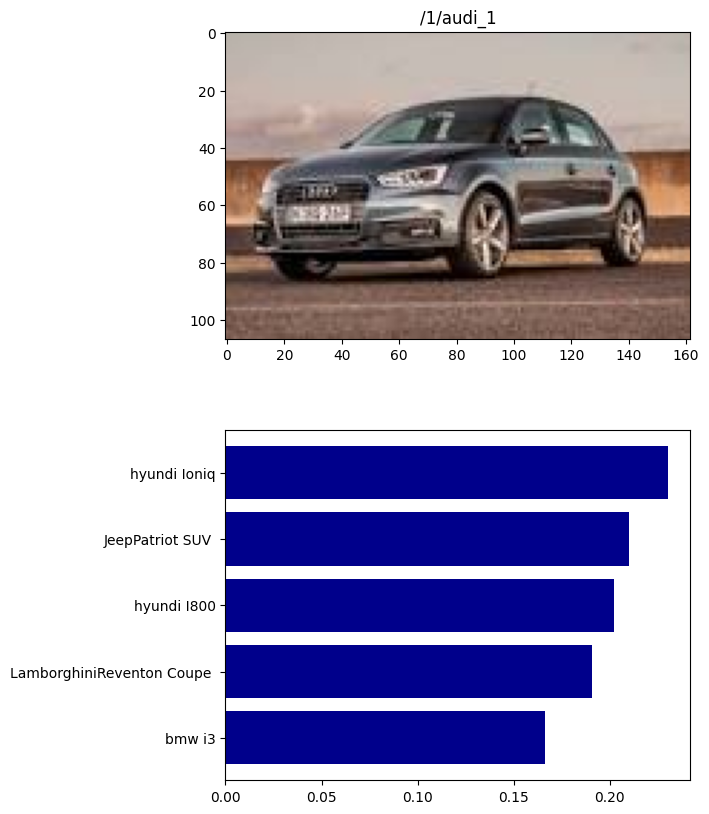

In [33]:
# Testing predict function

# Inputs are paths to saved model and test image
model_path = 'models/my_checkpoint2.pth'
carname = '/1/audi_1'
image_path = data_dir + carname


conf2, predicted1 = predict(image_path, model_path, topk=5)
# Converting classes to names
names = []
for i in range(5):
  
    names += [classes[predicted1[i]]]

# Creating PIL image
image = Image.open(image_path+'.jpg')

# Plotting test image and predicted probabilites
f, ax = plt.subplots(2,figsize = (6,10))

ax[0].imshow(image)
ax[0].set_title(carname)

y_names = np.arange(len(names))
ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
ax[1].set_yticks(y_names)
ax[1].set_yticklabels(names)
ax[1].invert_yaxis() 

plt.show()

In [34]:
def plot_solution(cardir, model):
  # Testing predict function

  # Inputs are paths to saved model and test image
  model_path = 'models/my_checkpoint2.pth'
  image_path = data_dir + cardir
  carname = cardir.split('/')[1]

  conf2, predicted1 = predict(image_path, model_path, topk=5)
  # Converting classes to names
  names = []
  for i in range(5):
  
      names += [classes[predicted1[i]]]


  # Creating PIL image
  image = Image.open(image_path+'.jpg')

  # Plotting test image and predicted probabilites
  f, ax = plt.subplots(2,figsize = (6,10))

  ax[0].imshow(image)
  ax[0].set_title(carname)

  y_names = np.arange(len(names))
  ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
  ax[1].set_yticks(y_names)
  ax[1].set_yticklabels(names)
  ax[1].invert_yaxis() 

  plt.show()

In [35]:
# Add Section that maps class_names.csv to classes for plotting. 

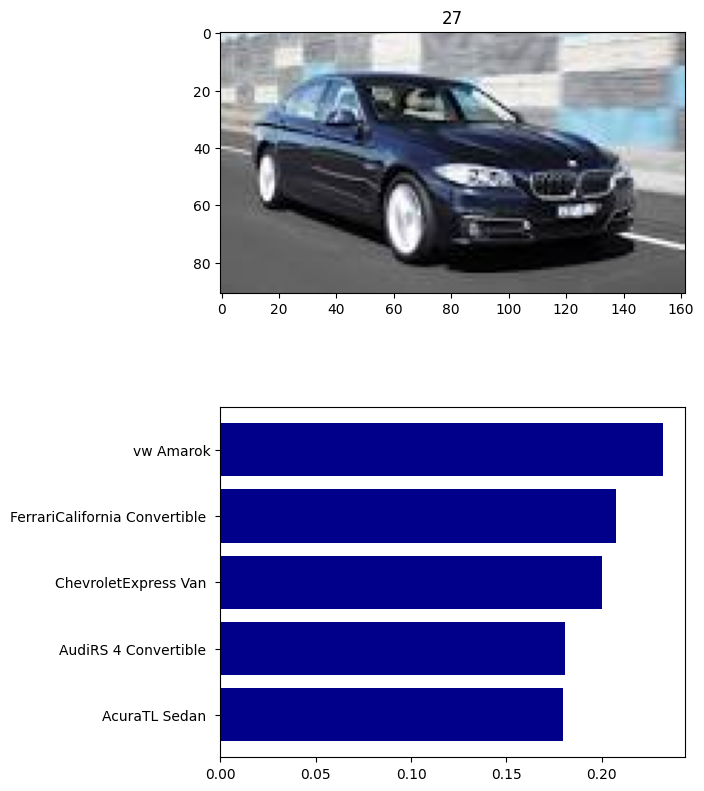

In [36]:
cardir='/27/bmw_1'
plot_solution(cardir, model)

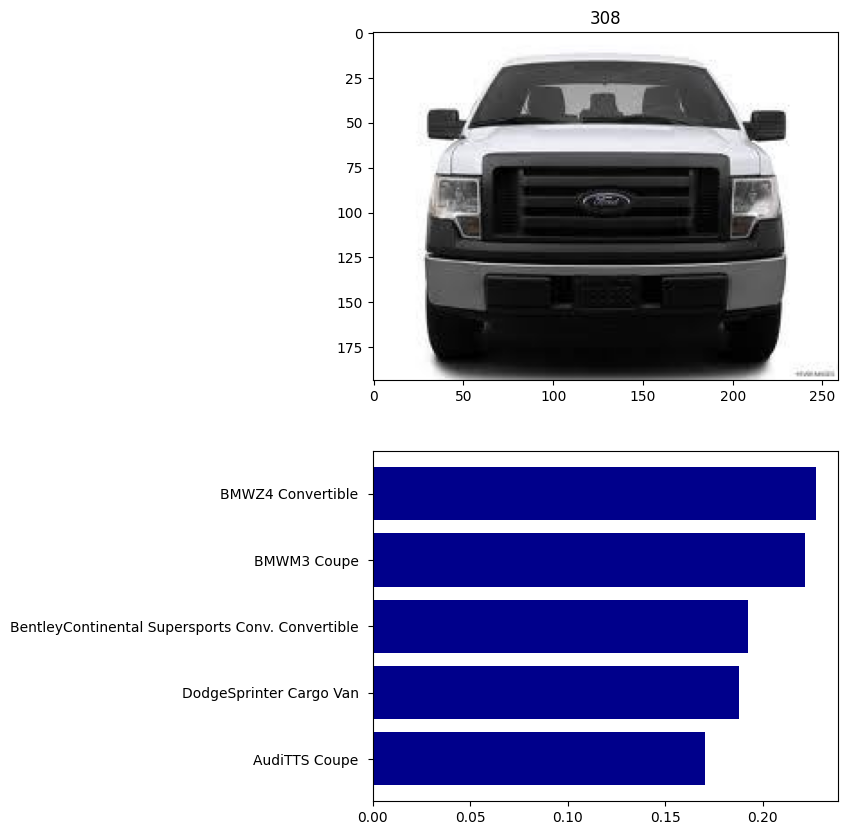

In [37]:
cardir='/308/00345'
plot_solution(cardir, model)